In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# ROOT = "/content/drive/My Drive/Practice/RL/PG"

In [ ]:
# %%capture
# !pip install box2d-py

In [ ]:
import os
import cv2
import gym
import time

import numpy as np
import torch as T
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

%matplotlib inline

In [ ]:
# T.cuda.get_device_name()

'Tesla T4'

## **Memory**

In [ ]:
class Memory:
    def __init__(self):
        self.states = []
        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.terminals = []

    def store_step(self, state, action, logprob, reward, terminal):
        self.states.append(T.tensor(state, dtype=T.float32))
        self.actions.append(T.tensor(action, dtype=T.float32))
        self.logprobs.append(T.tensor(logprob, dtype=T.float32))
        self.rewards.append(T.tensor(reward, dtype=T.float32))
        self.terminals.append(T.tensor(terminal, dtype=T.bool))
    
    def clear(self):
        del self.states[:]
        del self.actions[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.terminals[:]

    def __len__(self):
        return len(self.states)

## **Network**

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, lr, observation_shape, n_actions, model_name, model_dir, old_policy = False):
        super().__init__()
        self.model_dir = model_dir
        self.model_file = os.path.join(self.model_dir, model_name)

        # ACTOR
        self.actor = nn.Sequential(
            nn.Linear(observation_shape[0], 256),
            nn.LeakyReLU(),
            nn.Linear(256, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 64),
            nn.Tanh(),
            nn.Linear(64, n_actions),
        )

        # CRITIC
        self.critic = nn.Sequential(
            nn.Linear(observation_shape[0], 256),
            nn.LeakyReLU(),
            nn.Linear(256, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
        )

        # UTILS
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.loss = nn.SmoothL1Loss()
        if(not old_policy):
            self.optimizer = optim.Adam(self.parameters(), lr=lr, betas=(0.9, 0.999))
        self.to(self.device)

    def forward(self):
        raise NotImplementedError # CUSTOM actor & critic

    def save_model(self):
        print("[INFO] - Saving model")
        checkpoint = {
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict' : self.optimizer.state_dict()
        }
        T.save(checkpoint, self.model_file)
    
    def load_model(self, cpu=False):
        print("[INFO] - Loading model")
        
        map_location = T.device('cpu') if (cpu) else None
        
        checkpoint = T.load(self.model_file, map_location=map_location)
        self.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

## **Agent**

In [ ]:
class PPOAgent:
    def __init__(self, observation_shape, n_actions, lr, gamma, epsilon_clip, k_epochs, policy_update_frequency, algo_name, env_name, model_dir):
        self.observation_shape = observation_shape
        self.n_actions = n_actions
        self.LR = lr
        self.GAMMA = gamma
        self.EPS_CLIP = epsilon_clip
        self.K_EPOCHS = k_epochs
        # MEMORY
        self.memory = Memory()
        # NETWORK
        self.move_counter = 0
        self.policy_update_frequency = policy_update_frequency
        self.policy = PolicyNetwork(lr, observation_shape, n_actions,
                                    model_name = env_name+'_'+algo_name+'.pth',
                                    model_dir = model_dir)
        self.policy_old = PolicyNetwork(lr, observation_shape, n_actions,
                                    model_name = 'UNSAVED',
                                    model_dir = 'UNSAVED',
                                    old_policy = True)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
    

    def get_action(self, observation, eval=False):
        if(not eval):
            self.policy_old.eval()
            # USE policy_old DURING TRAIN
            observation = T.tensor([observation], dtype=T.float32).to(self.policy_old.device)
            probabilities = self.policy_old.actor(observation)
            probabilities = F.softmax(probabilities, dim=1)
            action_distribution = T.distributions.Categorical(probabilities)
            action = action_distribution.sample()
            logprob = action_distribution.log_prob(action)
            self.policy_old.train()
            return action.item(), logprob.item()
        else:
            # USE policy DURING EVAL
            self.policy.eval()
            observation = T.tensor([observation], dtype=T.float32).to(self.policy.device)
            probabilities = self.policy.actor(observation)
            probabilities = F.softmax(probabilities, dim=1)
            action = T.argmax(probabilities)
            self.policy.train()
            return action.item()

    # EVALUATE USING policy WITH grad
    def get_value(self, observations, actions):
        probabilities = self.policy.actor(observations)
        probabilities = F.softmax(probabilities, dim=1)
        action_distribution = T.distributions.Categorical(probabilities)
        logprobs = action_distribution.log_prob(actions)
        entropy = action_distribution.entropy()
        state_values = self.policy.critic(observations)
        return T.squeeze(state_values), logprobs, entropy

    def learn(self):
        # MONTE CARLO VALUE ESTIMATE
        G = []
        G_t = 0
        for old_reward, old_terminal in zip(reversed(self.memory.rewards), reversed(self.memory.terminals)):
            if old_terminal: 
                G_t = 0
            G_t = old_reward + (self.GAMMA * G_t)
            G.insert(0, G_t.item())
        
        old_rewards = T.tensor(G, dtype=T.float32).to(self.policy.device)
        old_rewards = (old_rewards - old_rewards.mean()) / (old_rewards.std() + 1e-5)
        
        # TO TENSOR (actions taken by policy_old)
        old_states = T.stack(self.memory.states).to(self.policy.device).detach()
        old_actions = T.stack(self.memory.actions).to(self.policy.device).detach()
        old_logprobs = T.stack(self.memory.logprobs).to(self.policy.device).detach()

        # OPTIMISE POLICY FOR k_epochs
        for _ in range(self.K_EPOCHS):
            # EVALUATE old_actions ON old_states
            state_values, logprobs, entropy = self.get_value(old_states, old_actions)
            # RATIO (pi_theta / pi_theta__old):
            ratios = T.exp(logprobs - old_logprobs.detach())
            # Finding Surrogate Loss:
            advantages = old_rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = T.clamp(ratios, 1-self.EPS_CLIP, 1+self.EPS_CLIP) * advantages
            loss = -T.min(surr1, surr2) + 0.5*self.policy.loss(state_values, old_rewards) - 0.01*entropy
            # TAKE GRAD STEP
            self.policy.optimizer.zero_grad()
            loss.mean().backward()
            self.policy.optimizer.step()
        
        self.policy_old.load_state_dict(self.policy.state_dict())

    def save_models(self):
        self.policy.save_model()
    
    def load_models(self, cpu=False):
        self.policy.load_model(cpu)

## **Training**

In [ ]:
env_name = "LunarLander-v2"
env = gym.make(env_name)

In [ ]:
agent = PPOAgent(observation_shape = env.observation_space.shape,
                 n_actions = env.action_space.n,
                 lr = 1e-4,
                 gamma = 0.99,
                 epsilon_clip = 0.2,
                 k_epochs = 8,
                 policy_update_frequency = 1200,
                 algo_name = 'PPO',
                 env_name = env_name,
                 model_dir = '.')

In [ ]:
N_EPISODES = 2000

episode_rewards, episode_lengths, mean_rewards = [],[],[]
best_reward = -np.inf

In [ ]:
for episode_n in tqdm(range(N_EPISODES)):
    total_reward, total_moves = 0,0

    done = False
    observation = env.reset()

    while not done:
        agent.move_counter += 1
        # RUNNING policy_old:
        action, logprob = agent.get_action(observation)
        observation_, reward, done, _ = env.step(action)

        agent.memory.store_step(observation, action, logprob, reward, done)
        total_reward += reward
        total_moves += 1

        if ((agent.move_counter % agent.policy_update_frequency) == 0):
            agent.learn()
            agent.memory.clear()
        
        if (total_moves > 300):
            break
        observation = observation_
        
    episode_rewards.append(total_reward)
    episode_lengths.append(total_moves)

    mean_reward = np.mean(episode_rewards[-100:])
    mean_rewards.append(mean_reward)
    if(mean_reward > best_reward):
        best_reward = mean_reward
        agent.save_models()
        
    print("ITER: ",episode_n,"\tRWD: ",round(total_reward,2),"\tM_RWD: ",round(mean_reward,2),"\tLEN: ",total_moves)

## **Graphs**

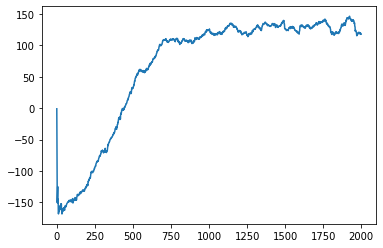

In [ ]:
plt.plot(mean_rewards) #6 new arch, SmoothL1, Tanh (1e-4)

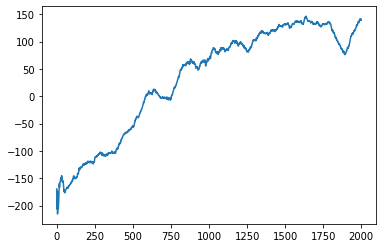

In [ ]:
splt.plot(mean_rewards) #4 SmoothL1, Tanh (1e-3)